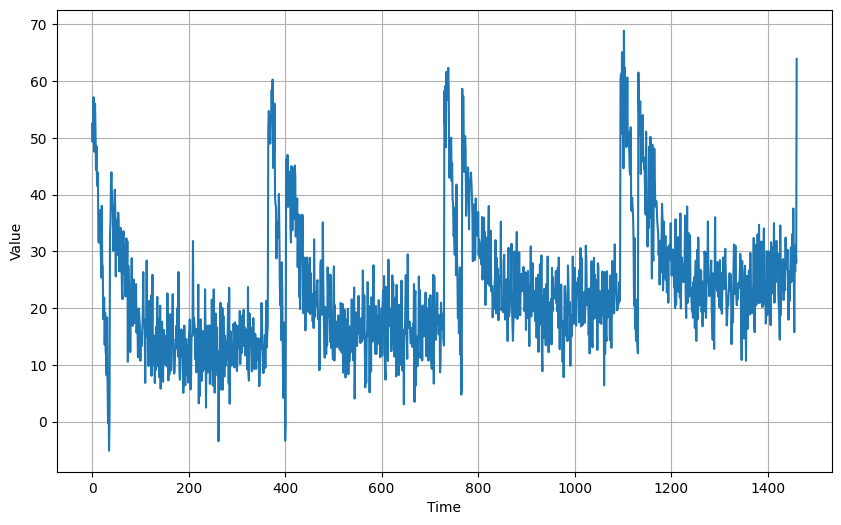

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Générer des données de série temporelle
time = np.arange(4 * 365 + 1, dtype="float32")

# Définir les paramètres
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 5

# Créer la série temporelle
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

# Tracer la série temporelle
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [32]:
import pandas as pd

# Charger le fichier CSV dans un DataFrame
file_path = 'stock_market_dataset.csv'
data = pd.read_csv('stock_market_dataset.csv')

# Afficher les premières lignes du DataFrame
premieres_lignes = data.head()
print(premieres_lignes)

           unix        date    symbol    open    high     low   close  \
0  1.640560e+12  12-27-2021  XRP-USDT  0.9200  0.9237  0.9200  0.9226   
1  1.640480e+12  12-26-2021  XRP-USDT  0.9252  0.9334  0.9052  0.9200   
2  1.640390e+12  12-25-2021  XRP-USDT  0.9114  0.9350  0.8981  0.9252   
3  1.640300e+12  12-24-2021  XRP-USDT  0.9941  0.9966  0.8964  0.9115   
4  1.640220e+12  12-23-2021  XRP-USDT  0.9538  1.0167  0.9372  0.9941   

    Volume XRP   Volume USDT  
0    2384512.0  2.198450e+06  
1  163438501.0  1.499400e+08  
2  250074945.0  2.302303e+08  
3  567234092.0  5.377035e+08  
4  479436230.0  4.729372e+08  


In [35]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Charger le fichier CSV dans un DataFrame
file_path = 'stock_market_dataset.csv'
data = pd.read_csv('stock_market_dataset.csv')

# Supprimer les colonnes inutiles
# Supposons que 'unix' et 'symbol' ne sont pas nécessaires pour cette analyse
data_cleaned = data.drop(columns=['unix', 'symbol'])

# Créer une colonne cible pour le prix de clôture du lendemain
data_cleaned['target_next_day_close'] = data_cleaned['close'].shift(-1)

# Supprimer la dernière ligne car elle n'aura pas de valeur cible
data_cleaned = data_cleaned.dropna(subset=['target_next_day_close'])

# Normaliser le jeu de données en utilisant MinMaxScaler
scaler = MinMaxScaler()

# Normaliser toutes les colonnes sauf la colonne 'date'
columns_to_normalize = data_cleaned.columns.difference(['date'])
data_normalized = data_cleaned.copy()
data_normalized[columns_to_normalize] = scaler.fit_transform(data_cleaned[columns_to_normalize])

# Sauvegarder le jeu de données normalisé dans un fichier CSV
output_file_path = 'normalized_stock_market_dataset.csv'
data_normalized.to_csv(output_file_path, index=False)

In [54]:
import pandas as pd

# Charger le fichier CSV dans un DataFrame
file_path = 'normalized_stock_market_dataset.csv'
data_normalized = pd.read_csv('stock_market_dataset.csv')

# Afficher les premières lignes du DataFrame pour vérifier le chargement
print(data_normalized.head())

           unix        date    symbol    open    high     low   close  \
0  1.640560e+12  12-27-2021  XRP-USDT  0.9200  0.9237  0.9200  0.9226   
1  1.640480e+12  12-26-2021  XRP-USDT  0.9252  0.9334  0.9052  0.9200   
2  1.640390e+12  12-25-2021  XRP-USDT  0.9114  0.9350  0.8981  0.9252   
3  1.640300e+12  12-24-2021  XRP-USDT  0.9941  0.9966  0.8964  0.9115   
4  1.640220e+12  12-23-2021  XRP-USDT  0.9538  1.0167  0.9372  0.9941   

    Volume XRP   Volume USDT  
0    2384512.0  2.198450e+06  
1  163438501.0  1.499400e+08  
2  250074945.0  2.302303e+08  
3  567234092.0  5.377035e+08  
4  479436230.0  4.729372e+08  


In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
file_path = 'normalized_stock_market_dataset.csv'
data_normalized = pd.read_csv('stock_market_dataset.csv')

# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(data_normalized))
val_size = int(0.15 * len(data_normalized))
test_size = len(data_normalized) - train_size - val_size

train_data, val_data, test_data = random_split(data_normalized, [train_size, val_size, test_size])

# Custom PyTorch Dataset class
class StockMarketDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.data_array = data[['open', 'high', 'low', 'close', 'Volume XRP', 'Volume USDT', 'target_next_day_close']].to_numpy()
        self.data_tensor = torch.FloatTensor(self.data_array)

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        features = self.data_tensor[idx, :-1]
        target = self.data_tensor[idx, -1]
        return features, target

# Create Dataset instances
train_dataset = StockMarketDataset(train_data)
val_dataset = StockMarketDataset(val_data)
test_dataset = StockMarketDataset(test_data)

# Define batch size
batch_size = 64

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Output the sizes of the datasets
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

In [55]:
# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the sizes of the datasets
print("Training set size:", len(train_loader.dataset))
print("Validation set size:", len(val_loader.dataset))
print("Testing set size:", len(test_loader.dataset))

Training set size: 933
Validation set size: 199
Testing set size: 201


In [56]:
import torch
import torch.nn as nn

class StockMarketLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super(StockMarketLSTM, self).__init__()

        # Define the LSTM layer
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)

        # Define the dropout layer
        self.dropout = nn.Dropout(0.2)

        # Define the output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Forward pass through LSTM layer
        lstm_out, _ = self.lstm(input_seq)

        # Apply dropout
        lstm_out = self.dropout(lstm_out)

        # Only take the output from the final time step
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Example usage:
# input_size = number of features
# hidden_layer_size = number of features in hidden state
# output_size = number of output features
input_size = 6  # open, high, low, close, Volume XRP, Volume USDT
hidden_layer_size = 50
output_size = 1  # target_next_day_close

model = StockMarketLSTM(input_size, hidden_layer_size, output_size)
print(model)

StockMarketLSTM(
  (lstm): LSTM(6, 50, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler

# Charger le jeu de données normalisé
file_path = 'normalized_stock_market_dataset.csv'
data_normalized = pd.read_csv(file_path)

# Diviser le jeu de données en ensembles d'entraînement, de validation et de test
train_size = int(0.7 * len(data_normalized))
val_size = int(0.15 * len(data_normalized))
test_size = len(data_normalized) - train_size - val_size

train_data, val_data, test_data = random_split(data_normalized, [train_size, val_size, test_size])

# Classe Dataset personnalisée pour PyTorch
class StockMarketDataset(Dataset):
    def __init__(self, data, original_dataframe):
        self.data_indices = data.indices
        self.original_dataframe = original_dataframe
        self.data_array = self.original_dataframe.loc[self.data_indices, ['open', 'high', 'low', 'close', 'Volume XRP', 'Volume USDT', 'target_next_day_close']].to_numpy()
        self.data_tensor = torch.FloatTensor(self.data_array)

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        features = self.data_tensor[idx, :-1]
        target = self.data_tensor[idx, -1]
        return features, target

# Créer des instances du Dataset
train_dataset = StockMarketDataset(train_data, data_normalized)
val_dataset = StockMarketDataset(val_data, data_normalized)
test_dataset = StockMarketDataset(test_data, data_normalized)

# Définir la taille des lots
batch_size = 64

# Créer des instances de DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Définir le modèle LSTM
class StockMarketLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super(StockMarketLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Définir le périphérique à utiliser (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialiser le modèle et le déplacer vers le périphérique
input_size = 6  # open, high, low, close, Volume XRP, Volume USDT
hidden_layer_size = 50
output_size = 1  # target_next_day_close

model = StockMarketLSTM(input_size, hidden_layer_size, output_size).to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Nombre d'époques
num_epochs = 100

# Boucle d'entraînement
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Boucle d'entraînement sur les lots
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1)

        # Passe avant
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Rétropropagation et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculer la perte moyenne d'entraînement pour l'époque
    train_loss /= len(train_loader)

    # Boucle de validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # Calculer la perte moyenne de validation pour l'époque
    val_loss /= len(val_loader)

    # Afficher la perte d'entraînement et de validation pour l'époque
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Optionnellement, sauvegarder le modèle entraîné
torch.save(model.state_dict(), 'stock_market_lstm.pth')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 1/100, Train Loss: 0.0412, Val Loss: 0.0307
Epoch 2/100, Train Loss: 0.0357, Val Loss: 0.0315
Epoch 3/100, Train Loss: 0.0357, Val Loss: 0.0312
Epoch 4/100, Train Loss: 0.0354, Val Loss: 0.0306
Epoch 5/100, Train Loss: 0.0358, Val Loss: 0.0309
Epoch 6/100, Train Loss: 0.0353, Val Loss: 0.0310
Epoch 7/100, Train Loss: 0.0359, Val Loss: 0.0307
Epoch 8/100, Train Loss: 0.0361, Val Loss: 0.0309
Epoch 9/100, Train Loss: 0.0352, Val Loss: 0.0311
Epoch 10/100, Train Loss: 0.0356, Val Loss: 0.0308
Epoch 11/100, Train Loss: 0.0354, Val Loss: 0.0309
Epoch 12/100, Train Loss: 0.0361, Val Loss: 0.0309
Epoch 13/100, Train Loss: 0.0352, Val Loss: 0.0311
Epoch 14/100, Train Loss: 0.0359, Val Loss: 0.0308
Epoch 15/100, Train Loss: 0.0351, Val Loss: 0.0311
Epoch 16/100, Train Loss: 0.0352, Val Loss: 0.0308
Epoch 17/100, Train Loss: 0.0351, Val Loss: 0.0311
Epoch 18/100, Train Loss: 0.0357, Val Loss: 0.0308
Epoch 19/100, Train Loss: 0.0350, Val Loss: 0.0309
Epoch 20/100, Train Loss: 0.0351, Val Lo

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 28/100, Train Loss: 0.0353, Val Loss: 0.0308
Epoch 29/100, Train Loss: 0.0361, Val Loss: 0.0310
Epoch 30/100, Train Loss: 0.0351, Val Loss: 0.0311
Epoch 31/100, Train Loss: 0.0352, Val Loss: 0.0309
Epoch 32/100, Train Loss: 0.0350, Val Loss: 0.0310
Epoch 33/100, Train Loss: 0.0348, Val Loss: 0.0309
Epoch 34/100, Train Loss: 0.0352, Val Loss: 0.0310
Epoch 35/100, Train Loss: 0.0357, Val Loss: 0.0308
Epoch 36/100, Train Loss: 0.0356, Val Loss: 0.0310
Epoch 37/100, Train Loss: 0.0353, Val Loss: 0.0310
Epoch 38/100, Train Loss: 0.0352, Val Loss: 0.0308
Epoch 39/100, Train Loss: 0.0349, Val Loss: 0.0312
Epoch 40/100, Train Loss: 0.0356, Val Loss: 0.0309
Epoch 41/100, Train Loss: 0.0352, Val Loss: 0.0309
Epoch 42/100, Train Loss: 0.0350, Val Loss: 0.0308
Epoch 43/100, Train Loss: 0.0357, Val Loss: 0.0310
Epoch 44/100, Train Loss: 0.0353, Val Loss: 0.0309
Epoch 45/100, Train Loss: 0.0349, Val Loss: 0.0310
Epoch 46/100, Train Loss: 0.0352, Val Loss: 0.0310
Epoch 47/100, Train Loss: 0.034

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 67/100, Train Loss: 0.0360, Val Loss: 0.0308
Epoch 68/100, Train Loss: 0.0352, Val Loss: 0.0313
Epoch 69/100, Train Loss: 0.0355, Val Loss: 0.0308
Epoch 70/100, Train Loss: 0.0355, Val Loss: 0.0309
Epoch 71/100, Train Loss: 0.0354, Val Loss: 0.0309
Epoch 72/100, Train Loss: 0.0358, Val Loss: 0.0312
Epoch 73/100, Train Loss: 0.0358, Val Loss: 0.0308
Epoch 74/100, Train Loss: 0.0353, Val Loss: 0.0309
Epoch 75/100, Train Loss: 0.0351, Val Loss: 0.0311
Epoch 76/100, Train Loss: 0.0351, Val Loss: 0.0309
Epoch 77/100, Train Loss: 0.0352, Val Loss: 0.0311
Epoch 78/100, Train Loss: 0.0358, Val Loss: 0.0308
Epoch 79/100, Train Loss: 0.0353, Val Loss: 0.0311
Epoch 80/100, Train Loss: 0.0352, Val Loss: 0.0309
Epoch 81/100, Train Loss: 0.0349, Val Loss: 0.0310
Epoch 82/100, Train Loss: 0.0351, Val Loss: 0.0309


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 83/100, Train Loss: 0.0353, Val Loss: 0.0308
Epoch 84/100, Train Loss: 0.0361, Val Loss: 0.0310
Epoch 85/100, Train Loss: 0.0354, Val Loss: 0.0310
Epoch 86/100, Train Loss: 0.0353, Val Loss: 0.0311
Epoch 87/100, Train Loss: 0.0354, Val Loss: 0.0308
Epoch 88/100, Train Loss: 0.0351, Val Loss: 0.0311
Epoch 89/100, Train Loss: 0.0351, Val Loss: 0.0309
Epoch 90/100, Train Loss: 0.0348, Val Loss: 0.0309
Epoch 91/100, Train Loss: 0.0349, Val Loss: 0.0310
Epoch 92/100, Train Loss: 0.0348, Val Loss: 0.0311
Epoch 93/100, Train Loss: 0.0352, Val Loss: 0.0309
Epoch 94/100, Train Loss: 0.0347, Val Loss: 0.0308
Epoch 95/100, Train Loss: 0.0356, Val Loss: 0.0308
Epoch 96/100, Train Loss: 0.0353, Val Loss: 0.0309
Epoch 97/100, Train Loss: 0.0356, Val Loss: 0.0311


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 98/100, Train Loss: 0.0363, Val Loss: 0.0309
Epoch 99/100, Train Loss: 0.0353, Val Loss: 0.0311
Epoch 100/100, Train Loss: 0.0352, Val Loss: 0.0309


In [52]:
import torch
import numpy as np
from sklearn.metrics import r2_score
import joblib

# Load the trained model
model.load_state_dict(torch.load('stock_market_lstm.pth'))
model.eval()

# Lists to store the actual and predicted values
actuals = []
predictions = []

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

# Calculate the R² score
r2 = r2_score(actuals, predictions)
print(f'R² Score: {r2:.4f}')

# Save the scaler object for future predictions
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename)

R² Score: 0.0268


['scaler.save']

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import joblib

# Load your dataset
file_path = 'normalized_stock_market_dataset.csv'
data_normalized = pd.read_csv(file_path)

# Define the device to use (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom PyTorch Dataset class
class StockMarketDataset(Dataset):
    def __init__(self, data, original_dataframe):
        self.data_indices = data.indices
        self.original_dataframe = original_dataframe
        self.data_array = self.original_dataframe.loc[self.data_indices, ['open', 'high', 'low', 'close', 'Volume XRP', 'Volume USDT', 'target_next_day_close']].to_numpy()
        self.data_tensor = torch.FloatTensor(self.data_array)

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        features = self.data_tensor[idx, :-1]
        target = self.data_tensor[idx, -1]
        return features, target

# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(data_normalized))
val_size = int(0.15 * len(data_normalized))
test_size = len(data_normalized) - train_size - val_size

train_data, val_data, test_data = random_split(data_normalized, [train_size, val_size, test_size])

# Create Dataset instances
train_dataset = StockMarketDataset(train_data, data_normalized)
val_dataset = StockMarketDataset(val_data, data_normalized)
test_dataset = StockMarketDataset(test_data, data_normalized)

# Define batch size
batch_size = 64

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM model
class StockMarketLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super(StockMarketLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Initialize the model and move it to the device
input_size = 6  # open, high, low, close, Volume XRP, Volume USDT
hidden_layer_size = 50
output_size = 1  # target_next_day_close

model = StockMarketLSTM(input_size, hidden_layer_size, output_size).to(device)

# Load the trained model
model.load_state_dict(torch.load('stock_market_lstm.pth'))
model.eval()

# Lists to store the actual and predicted values
actuals = []
predictions = []

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

# Calculate the R² score
r2 = r2_score(actuals, predictions)
print(f'R² Score: {r2:.4f}')

# Save the scaler object for future predictions
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename)

R² Score: 0.0397


['scaler.save']

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
file_path = 'normalized_stock_market_dataset.csv'
data_normalized = pd.read_csv(file_path)

# Define the device to use (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom PyTorch Dataset class
class StockMarketDataset(Dataset):
    def __init__(self, data, original_dataframe):
        self.data_indices = data.indices
        self.original_dataframe = original_dataframe
        self.data_array = self.original_dataframe.loc[self.data_indices, ['open', 'high', 'low', 'close', 'Volume XRP', 'Volume USDT', 'target_next_day_close']].to_numpy()
        self.data_tensor = torch.FloatTensor(self.data_array)

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        features = self.data_tensor[idx, :-1]
        target = self.data_tensor[idx, -1]
        return features, target

# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(data_normalized))
val_size = int(0.15 * len(data_normalized))
test_size = len(data_normalized) - train_size - val_size

train_data, val_data, test_data = random_split(data_normalized, [train_size, val_size, test_size])

# Create Dataset instances
train_dataset = StockMarketDataset(train_data, data_normalized)
val_dataset = StockMarketDataset(val_data, data_normalized)
test_dataset = StockMarketDataset(test_data, data_normalized)

# Define batch size
batch_size = 64

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM model
class StockMarketLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super(StockMarketLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Initialize the model and move it to the device
input_size = 6  # open, high, low, close, Volume XRP, Volume USDT
hidden_layer_size = 50
output_size = 1  # target_next_day_close

model = StockMarketLSTM(input_size, hidden_layer_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training loop over batches
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1)  # Reshape inputs to (batch_size, sequence_length, input_size)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    val_loss /= len(val_loader)

    # Print training and validation loss for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'stock_market_lstm.pth')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 1/100, Train Loss: 0.0371, Val Loss: 0.0342
Epoch 2/100, Train Loss: 0.0359, Val Loss: 0.0343
Epoch 3/100, Train Loss: 0.0362, Val Loss: 0.0341


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 4/100, Train Loss: 0.0356, Val Loss: 0.0341
Epoch 5/100, Train Loss: 0.0362, Val Loss: 0.0341
Epoch 6/100, Train Loss: 0.0356, Val Loss: 0.0342
Epoch 7/100, Train Loss: 0.0356, Val Loss: 0.0341
Epoch 8/100, Train Loss: 0.0358, Val Loss: 0.0341
Epoch 9/100, Train Loss: 0.0355, Val Loss: 0.0343
Epoch 10/100, Train Loss: 0.0359, Val Loss: 0.0341
Epoch 11/100, Train Loss: 0.0359, Val Loss: 0.0341
Epoch 12/100, Train Loss: 0.0363, Val Loss: 0.0341
Epoch 13/100, Train Loss: 0.0358, Val Loss: 0.0341
Epoch 14/100, Train Loss: 0.0361, Val Loss: 0.0341
Epoch 15/100, Train Loss: 0.0357, Val Loss: 0.0342
Epoch 16/100, Train Loss: 0.0357, Val Loss: 0.0341
Epoch 17/100, Train Loss: 0.0362, Val Loss: 0.0341
Epoch 18/100, Train Loss: 0.0353, Val Loss: 0.0342
Epoch 19/100, Train Loss: 0.0358, Val Loss: 0.0341
Epoch 20/100, Train Loss: 0.0359, Val Loss: 0.0341
Epoch 21/100, Train Loss: 0.0357, Val Loss: 0.0341
Epoch 22/100, Train Loss: 0.0357, Val Loss: 0.0341
Epoch 23/100, Train Loss: 0.0358, Val

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 32/100, Train Loss: 0.0356, Val Loss: 0.0341
Epoch 33/100, Train Loss: 0.0352, Val Loss: 0.0342
Epoch 34/100, Train Loss: 0.0353, Val Loss: 0.0341
Epoch 35/100, Train Loss: 0.0358, Val Loss: 0.0341
Epoch 36/100, Train Loss: 0.0354, Val Loss: 0.0341
Epoch 37/100, Train Loss: 0.0355, Val Loss: 0.0341
Epoch 38/100, Train Loss: 0.0369, Val Loss: 0.0341
Epoch 39/100, Train Loss: 0.0358, Val Loss: 0.0341
Epoch 40/100, Train Loss: 0.0353, Val Loss: 0.0341
Epoch 41/100, Train Loss: 0.0355, Val Loss: 0.0341
Epoch 42/100, Train Loss: 0.0358, Val Loss: 0.0341
Epoch 43/100, Train Loss: 0.0361, Val Loss: 0.0341
Epoch 44/100, Train Loss: 0.0355, Val Loss: 0.0342
Epoch 45/100, Train Loss: 0.0362, Val Loss: 0.0341
Epoch 46/100, Train Loss: 0.0353, Val Loss: 0.0342
Epoch 47/100, Train Loss: 0.0362, Val Loss: 0.0341
Epoch 48/100, Train Loss: 0.0352, Val Loss: 0.0342
Epoch 49/100, Train Loss: 0.0358, Val Loss: 0.0341
Epoch 50/100, Train Loss: 0.0359, Val Loss: 0.0341
Epoch 51/100, Train Loss: 0.035

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 65/100, Train Loss: 0.0363, Val Loss: 0.0341
Epoch 66/100, Train Loss: 0.0359, Val Loss: 0.0342
Epoch 67/100, Train Loss: 0.0355, Val Loss: 0.0341
Epoch 68/100, Train Loss: 0.0361, Val Loss: 0.0341
Epoch 69/100, Train Loss: 0.0356, Val Loss: 0.0341
Epoch 70/100, Train Loss: 0.0360, Val Loss: 0.0342
Epoch 71/100, Train Loss: 0.0357, Val Loss: 0.0341
Epoch 72/100, Train Loss: 0.0357, Val Loss: 0.0341


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 73/100, Train Loss: 0.0359, Val Loss: 0.0341
Epoch 74/100, Train Loss: 0.0356, Val Loss: 0.0342
Epoch 75/100, Train Loss: 0.0359, Val Loss: 0.0341
Epoch 76/100, Train Loss: 0.0361, Val Loss: 0.0341
Epoch 77/100, Train Loss: 0.0354, Val Loss: 0.0342
Epoch 78/100, Train Loss: 0.0363, Val Loss: 0.0341
Epoch 79/100, Train Loss: 0.0358, Val Loss: 0.0342
Epoch 80/100, Train Loss: 0.0361, Val Loss: 0.0341
Epoch 81/100, Train Loss: 0.0357, Val Loss: 0.0341
Epoch 82/100, Train Loss: 0.0359, Val Loss: 0.0341
Epoch 83/100, Train Loss: 0.0351, Val Loss: 0.0341
Epoch 84/100, Train Loss: 0.0357, Val Loss: 0.0341
Epoch 85/100, Train Loss: 0.0358, Val Loss: 0.0341
Epoch 86/100, Train Loss: 0.0359, Val Loss: 0.0341
Epoch 87/100, Train Loss: 0.0361, Val Loss: 0.0342
Epoch 88/100, Train Loss: 0.0361, Val Loss: 0.0341
Epoch 89/100, Train Loss: 0.0353, Val Loss: 0.0341
Epoch 90/100, Train Loss: 0.0359, Val Loss: 0.0341
Epoch 91/100, Train Loss: 0.0360, Val Loss: 0.0341


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 92/100, Train Loss: 0.0354, Val Loss: 0.0342
Epoch 93/100, Train Loss: 0.0358, Val Loss: 0.0341
Epoch 94/100, Train Loss: 0.0356, Val Loss: 0.0341
Epoch 95/100, Train Loss: 0.0354, Val Loss: 0.0341
Epoch 96/100, Train Loss: 0.0355, Val Loss: 0.0341
Epoch 97/100, Train Loss: 0.0355, Val Loss: 0.0341
Epoch 98/100, Train Loss: 0.0363, Val Loss: 0.0341
Epoch 99/100, Train Loss: 0.0356, Val Loss: 0.0341
Epoch 100/100, Train Loss: 0.0358, Val Loss: 0.0342


In [62]:
import torch
import numpy as np
from sklearn.metrics import r2_score
import joblib

# Load the trained model
model.load_state_dict(torch.load('stock_market_lstm.pth'))
model.eval()

# Lists to store the actual and predicted values
actuals = []
predictions = []

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1)  # Reshape inputs to (batch_size, sequence_length, input_size)
        outputs = model(inputs)
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

# Calculate the R² score
r2 = r2_score(actuals, predictions)
print(f'R² Score: {r2:.4f}')

# Save the scaler object for future predictions
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename)

R² Score: 0.0237


['scaler.save']

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Définir le modèle LSTM
class StockMarketLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super(StockMarketLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Paramètres du modèle
input_size = 6  # open, high, low, close, Volume XRP, Volume USDT
hidden_layer_size = 50
output_size = 1  # target_next_day_close

# Initialiser le modèle
model = StockMarketLSTM(input_size, hidden_layer_size, output_size)

# Définir le périphérique à utiliser (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Charger les poids du modèle si nécessaire
# model.load_state_dict(torch.load('stock_market_lstm.pth'))

# Assurez-vous que le modèle est en mode évaluation
model.eval()

# Lists pour stocker les valeurs réelles et prédites
actuals = []
predictions = []

# Évaluer le modèle sur l'ensemble de test
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1)  # Redimensionner les entrées
        outputs = model(inputs)
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

# Convertir les listes en tableaux NumPy
actuals = np.array(actuals)
predictions = np.array(predictions)

# Créer un tableau d'indices pour l'axe des x
indices = np.arange(len(actuals))

# Tracer les valeurs réelles et prédites
plt.figure(figsize=(10, 6))
plt.plot(indices, actuals, label='Valeurs Réelles')
plt.plot(indices, predictions, label='Valeurs Prédites')
plt.xlabel('Index')
plt.ylabel('Prix de Clôture')
plt.title('Comparaison des Valeurs Réelles et Prédites')
plt.legend()
plt.show()

# Calculer le score R²
r2 = r2_score(actuals, predictions)
print(f'R² Score: {r2:.4f}')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Charger et préparer les données
file_path = 'normalized_stock_market_dataset.csv'
data_normalized = pd.read_csv(file_path)

# Classe Dataset personnalisée pour PyTorch
class StockMarketDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.data_array = data[['open', 'high', 'low', 'close', 'Volume XRP', 'Volume USDT', 'target_next_day_close']].to_numpy()
        self.data_tensor = torch.FloatTensor(self.data_array)

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        features = self.data_tensor[idx, :-1]
        target = self.data_tensor[idx, -1]
        return features, target

# Diviser le jeu de données en ensembles d'entraînement, de validation et de test
train_size = int(0.7 * len(data_normalized))
val_size = int(0.15 * len(data_normalized))
test_size = len(data_normalized) - train_size - val_size

train_data, val_data, test_data = random_split(data_normalized, [train_size, val_size, test_size])

# Créer des instances du Dataset
train_dataset = StockMarketDataset(train_data)
val_dataset = StockMarketDataset(val_data)
test_dataset = StockMarketDataset(test_data)

# Définir la taille des lots
batch_size = 64

# Créer des instances de DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Définir le modèle LSTM
class StockMarketLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super(StockMarketLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Paramètres du modèle
input_size = 6  # open, high, low, close, Volume XRP, Volume USDT
hidden_layer_size = 50
output_size = 1  # target_next_day_close

# Initialiser le modèle
model = StockMarketLSTM(input_size, hidden_layer_size, output_size)

# Définir le périphérique à utiliser (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Assurez-vous que le modèle est en mode évaluation
model.eval()

# Lists pour stocker les valeurs réelles et prédites
actuals = []
predictions = []

# Évaluer le modèle sur l'ensemble de test
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1)  # Redimensionner les entrées
        outputs = model(inputs)
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

# Convertir les listes en tableaux NumPy
actuals = np.array(actuals)
predictions = np.array(predictions)

# Créer un tableau d'indices pour l'axe des x
indices = np.arange(len(actuals))

# Tracer les valeurs réelles et prédites
plt.figure(figsize=(10, 6))
plt.plot(indices, actuals, label='Valeurs Réelles')
plt.plot(indices, predictions, label='Valeurs Prédites')
plt.xlabel('Index')
plt.ylabel('Prix de Clôture')
plt.title('Comparaison des Valeurs Réelles et Prédites')
plt.legend()
plt.show()

# Calculer le score R²
r2 = r2_score(actuals, predictions)
print(f'R² Score: {r2:.4f}')